In [1]:
# library
# standard library
import os, sys

# third-party library
import numpy as np
import collections
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader
from dataset import dataset_processing
from timeit import default_timer as timer
from utils.report import report_precision_se_sp_yi, report_mae_mse
from utils.utils import Logger, AverageMeter, time_to_str, weights_init
from utils.genLD import genLD
from model.resnet50 import resnet50
import torch.backends.cudnn as cudnn
from transforms.affine_transforms import *
import time
import warnings
warnings.filterwarnings("ignore")
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
cnn = resnet50().cuda()      
checkpoint = torch.load('model_checkpoint.pth')
cnn.load_state_dict(checkpoint['model_state_dict'])
init_epoch = checkpoint['epoch']


In [3]:
init_epoch

110

In [4]:
LR = 0.001     

In [5]:
params = []
new_param_names = ['fc', 'counting']
for key, value in dict(cnn.named_parameters()).items():
    if value.requires_grad:
        if any(i in key for i in new_param_names):
            params += [{'params': [value], 'lr': LR * 1.0, 'weight_decay': 5e-4}]
        else:
            params += [{'params': [value], 'lr': LR * 1.0, 'weight_decay': 5e-4}]

optimizer = torch.optim.SGD(params, momentum=0.9)  #

optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [6]:
cnn.eval()

In [7]:
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.45815152, 0.361242, 0.29348266],
                             std=[0.2814769, 0.226306, 0.20132513])
  ])

In [8]:
cross_val_index = "0"

In [9]:
DATA_PATH = 'Classification/Classification/JPEGImages'


In [10]:
TRAIN_FILE = 'Detection/Detection/VOC2007/ImageSets/Main/NNEW_trainval_' + cross_val_index + '.txt'
TEST_FILE = 'Detection/Detection/VOC2007/ImageSets/Main/NNEW_test_' + cross_val_index + '.txt'

In [11]:
normalize = transforms.Normalize(mean=[0.45815152, 0.361242, 0.29348266],
                                     std=[0.2814769, 0.226306, 0.20132513])

In [12]:
dset_test = dataset_processing.DatasetProcessing(
    DATA_PATH, TEST_FILE, transform=transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            normalize,
        ]))

In [13]:
BATCH_SIZE = 32
NUM_WORKERS = 12
BATCH_SIZE_TEST = 20


In [14]:
test_loader = DataLoader(dset_test,
                             batch_size=BATCH_SIZE_TEST,
                             shuffle=False,
                             num_workers=NUM_WORKERS,
                             pin_memory=True)

In [15]:
test_dt = next(iter(test_loader))

In [26]:
test_dt[3]

['levle0_451.jpg',
 'levle0_498.jpg',
 'levle0_485.jpg',
 'levle0_218.jpg',
 'levle1_344.jpg',
 'levle0_302.jpg',
 'levle1_413.jpg',
 'levle0_210.jpg',
 'levle0_11.jpg',
 'levle0_83.jpg',
 'levle0_319.jpg',
 'levle0_64.jpg',
 'levle0_103.jpg',
 'levle0_213.jpg',
 'levle0_504.jpg',
 'levle0_432.jpg',
 'levle0_178.jpg',
 'levle0_202.jpg',
 'levle0_112.jpg',
 'levle0_241.jpg']

In [16]:
test_dt[1]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       dtype=torch.int32)

In [17]:
test_dt[2]

tensor([2, 1, 3, 2, 4, 2, 4, 2, 3, 1, 2, 2, 2, 2, 4, 2, 1, 2, 1, 2],
       dtype=torch.int32)

In [18]:
test_dt[0]

tensor([[[[-1.4605, -1.4883, -1.5023,  ..., -1.4883, -1.4744, -1.4744],
          [-1.4744, -1.4883, -1.5023,  ..., -1.4744, -1.4744, -1.4605],
          [-1.4744, -1.4883, -1.5023,  ..., -1.4744, -1.4744, -1.4744],
          ...,
          [-1.6277, -1.6277, -1.6277,  ..., -1.6277, -1.6277, -1.6277],
          [-1.6277, -1.6277, -1.6277,  ..., -1.6277, -1.6277, -1.6277],
          [-1.6277, -1.6277, -1.6277,  ..., -1.6277, -1.6277, -1.6277]],

         [[-1.3883, -1.4230, -1.4403,  ..., -1.4230, -1.4056, -1.4056],
          [-1.4056, -1.4230, -1.4403,  ..., -1.4056, -1.4056, -1.3883],
          [-1.4056, -1.4230, -1.4403,  ..., -1.4056, -1.4056, -1.4056],
          ...,
          [-1.5963, -1.5963, -1.5963,  ..., -1.5963, -1.5963, -1.5963],
          [-1.5963, -1.5963, -1.5963,  ..., -1.5963, -1.5963, -1.5963],
          [-1.5963, -1.5963, -1.5963,  ..., -1.5963, -1.5963, -1.5963]],

         [[-1.2240, -1.2630, -1.2824,  ..., -1.2630, -1.2435, -1.2630],
          [-1.2435, -1.2630, -

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


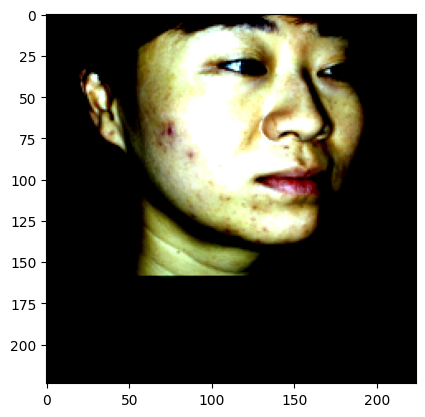

In [19]:
# show the image
import matplotlib.pyplot as plt
plt.imshow(test_dt[0][0].numpy().transpose(1,2,0))
plt.show()


In [20]:
test_x = test_dt[0].cuda()

cls, cou, cou2cls = cnn(test_x, None)


In [59]:
print(cls)

tensor([[5.9725e-01, 4.0216e-01, 8.8662e-04, 1.0158e-04],
        [8.7390e-01, 1.2629e-01, 1.0795e-04, 1.0001e-04],
        [7.6391e-01, 2.3618e-01, 2.0647e-04, 1.0005e-04],
        [8.3672e-01, 1.6338e-01, 1.9623e-04, 1.0029e-04],
        [7.8814e-01, 2.1196e-01, 2.0084e-04, 1.0025e-04],
        [7.6206e-01, 2.3811e-01, 1.3445e-04, 1.0003e-04],
        [6.9829e-01, 3.0185e-01, 1.6080e-04, 1.0001e-04],
        [5.2397e-01, 4.7614e-01, 1.9714e-04, 1.0001e-04],
        [9.4801e-01, 5.2187e-02, 1.0331e-04, 1.0000e-04],
        [8.5660e-01, 1.4355e-01, 1.4789e-04, 1.0002e-04],
        [6.3925e-01, 3.6084e-01, 2.1227e-04, 1.0007e-04],
        [5.4588e-01, 4.5430e-01, 1.2674e-04, 1.0000e-04],
        [8.9161e-01, 1.0858e-01, 1.1078e-04, 1.0001e-04],
        [8.5348e-01, 1.4670e-01, 1.2033e-04, 1.0001e-04],
        [6.2008e-01, 3.8005e-01, 1.7278e-04, 1.0002e-04],
        [7.5137e-01, 2.4876e-01, 1.6774e-04, 1.0009e-04],
        [7.0249e-01, 2.9754e-01, 2.6903e-04, 1.0051e-04],
        [8.485

In [61]:
_label = torch.max(cls, 1)
_label

torch.return_types.max(
values=tensor([0.5973, 0.8739, 0.7639, 0.8367, 0.7881, 0.7621, 0.6983, 0.5240, 0.9480,
        0.8566, 0.6392, 0.5459, 0.8916, 0.8535, 0.6201, 0.7514, 0.7025, 0.8486,
        0.8624, 0.5389], device='cuda:0'),
indices=tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       device='cuda:0'))

In [21]:
# Kiểu mối quan hệ giữa số lượng đếm và label dự đoán.
print(cou2cls)

tensor([[0.5811, 0.4208, 0.0031, 0.0015],
        [0.8720, 0.1300, 0.0030, 0.0015],
        [0.7491, 0.2529, 0.0030, 0.0015],
        [0.8244, 0.1776, 0.0030, 0.0015],
        [0.7768, 0.2252, 0.0030, 0.0015],
        [0.7503, 0.2517, 0.0030, 0.0015],
        [0.6739, 0.3281, 0.0030, 0.0015],
        [0.4861, 0.5159, 0.0030, 0.0015],
        [0.9386, 0.0634, 0.0030, 0.0015],
        [0.8468, 0.1552, 0.0030, 0.0015],
        [0.6231, 0.3789, 0.0030, 0.0015],
        [0.5386, 0.4634, 0.0030, 0.0015],
        [0.8791, 0.1229, 0.0030, 0.0015],
        [0.8454, 0.1566, 0.0030, 0.0015],
        [0.5826, 0.4194, 0.0030, 0.0015],
        [0.7308, 0.2712, 0.0030, 0.0015],
        [0.6804, 0.3215, 0.0030, 0.0015],
        [0.8191, 0.1829, 0.0030, 0.0015],
        [0.8302, 0.1718, 0.0030, 0.0015],
        [0.4566, 0.5453, 0.0030, 0.0015]], device='cuda:0',
       grad_fn=<StackBackward0>)


In [62]:
_cou2cls = torch.max(cou2cls, 1)
_cou2cls

torch.return_types.max(
values=tensor([0.5811, 0.8720, 0.7491, 0.8244, 0.7768, 0.7503, 0.6739, 0.5159, 0.9386,
        0.8468, 0.6231, 0.5386, 0.8791, 0.8454, 0.5826, 0.7308, 0.6804, 0.8191,
        0.8302, 0.5453], device='cuda:0'),
indices=tensor([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       device='cuda:0'))

In [22]:
print(cou)

tensor([[8.5655e-02, 1.0657e-01, 1.2485e-01,  ..., 1.0017e-04, 1.0022e-04,
         1.0023e-04],
        [2.2121e-01, 2.1592e-01, 1.8995e-01,  ..., 1.0000e-04, 1.0000e-04,
         1.0000e-04],
        [1.4535e-01, 1.6257e-01, 1.6540e-01,  ..., 1.0000e-04, 1.0000e-04,
         1.0001e-04],
        ...,
        [1.7630e-01, 1.8863e-01, 1.7669e-01,  ..., 1.0000e-04, 1.0000e-04,
         1.0000e-04],
        [1.8443e-01, 1.9630e-01, 1.8288e-01,  ..., 1.0000e-04, 1.0000e-04,
         1.0000e-04],
        [5.7886e-02, 7.4905e-02, 9.4501e-02,  ..., 1.0003e-04, 1.0004e-04,
         1.0005e-04]], device='cuda:0', grad_fn=<AddBackward0>)


In [63]:
print(cou.shape)

torch.Size([20, 65])


In [23]:
_, preds_l = torch.max(cou, 1)

In [24]:
preds_l

tensor([4, 0, 2, 1, 1, 1, 3, 4, 0, 0, 3, 4, 0, 0, 4, 2, 3, 1, 1, 5],
       device='cuda:0')

In [27]:
test_dt[2]

tensor([2, 1, 3, 2, 4, 2, 4, 2, 3, 1, 2, 2, 2, 2, 4, 2, 1, 2, 1, 2],
       dtype=torch.int32)

In [33]:
# acc
corrects = torch.sum(preds_l == test_dt[2].cuda())
corrects

tensor(3, device='cuda:0')

In [34]:
corrects/len(test_dt[2])

tensor(0.1500, device='cuda:0')

tensor([[5.9725e-01, 4.0216e-01, 8.8662e-04, 1.0158e-04],
        [8.7390e-01, 1.2629e-01, 1.0795e-04, 1.0001e-04],
        [7.6391e-01, 2.3618e-01, 2.0647e-04, 1.0005e-04],
        [8.3672e-01, 1.6338e-01, 1.9623e-04, 1.0029e-04],
        [7.8814e-01, 2.1196e-01, 2.0084e-04, 1.0025e-04],
        [7.6206e-01, 2.3811e-01, 1.3445e-04, 1.0003e-04],
        [6.9829e-01, 3.0185e-01, 1.6080e-04, 1.0001e-04],
        [5.2397e-01, 4.7614e-01, 1.9714e-04, 1.0001e-04],
        [9.4801e-01, 5.2187e-02, 1.0331e-04, 1.0000e-04],
        [8.5660e-01, 1.4355e-01, 1.4789e-04, 1.0002e-04],
        [6.3925e-01, 3.6084e-01, 2.1227e-04, 1.0007e-04],
        [5.4588e-01, 4.5430e-01, 1.2674e-04, 1.0000e-04],
        [8.9161e-01, 1.0858e-01, 1.1078e-04, 1.0001e-04],
        [8.5348e-01, 1.4670e-01, 1.2033e-04, 1.0001e-04],
        [6.2008e-01, 3.8005e-01, 1.7278e-04, 1.0002e-04],
        [7.5137e-01, 2.4876e-01, 1.6774e-04, 1.0009e-04],
        [7.0249e-01, 2.9754e-01, 2.6903e-04, 1.0051e-04],
        [8.485

In [38]:
loss_func = nn.CrossEntropyLoss().cuda()
epoch = init_epoch

In [46]:
LOG_FILE_NAME = './logs/log_' + time.strftime("%Y-%m-%d_%H-%M-%S", time.localtime()) + '.log'


In [47]:
log = Logger()
log.open(LOG_FILE_NAME, mode="a")


In [58]:
with torch.no_grad():
    test_loss = 0
    test_corrects = 0
    count_corrects = 0
    y_true = np.array([])
    y_pred = np.array([])
    y_pred_m = np.array([])
    l_true = np.array([])
    l_pred = np.array([])
    cnn.eval()
    for step, (test_x, test_y, test_l, test_name) in enumerate(test_loader):   # gives batch data, normalize x when iterate train_loader

        test_x = test_x.cuda()
        test_y = test_y.cuda()

        y_true = np.hstack((y_true, test_y.data.cpu().numpy()))
        l_true = np.hstack((l_true, test_l.data.cpu().numpy()))

        cnn.eval()

        cls, cou, cou2cls = cnn(test_x, None)



        _, preds_m = torch.max(cls + cou2cls, 1)
  
        _, preds = torch.max(cls, 1)
        # preds = preds.data.cpu().numpy()
        y_pred = np.hstack((y_pred, preds.data.cpu().numpy()))
        y_pred_m = np.hstack((y_pred_m, preds_m.data.cpu().numpy()))

        _, preds_l = torch.max(cou, 1)
        preds_l = (preds_l + 1).data.cpu().numpy()
        # preds_l = cou2cou.data.cpu().numpy()
        l_pred = np.hstack((l_pred, preds_l))

        batch_corrects = torch.sum((preds == test_y)).data.cpu().numpy()
        test_corrects += batch_corrects
        print("preds_l", preds_l)
        print("test_l",test_l)
        print("preds", preds)
        print("test_y", test_y)
        
        print('batch_corrects', batch_corrects)
        print('test_corrects', test_corrects)
        
        # preds_l to tensor
        preds_l = torch.from_numpy(preds_l).cpu()
        count_corrects +=  torch.sum((preds_l == test_l)).data.cpu().numpy()
        # mse preds_l and test_l
        count_mse = torch.sum((preds_l - test_l)**2).data.cpu().numpy()
        print('count_corrects', count_corrects)
        print('count_mse', count_mse)
        
        break
        
    print("Len", len(test_loader.dataset))
    test_acc = test_corrects / len(test_loader.dataset)#3292  #len(test_loader)
    message = '%s %6.1f | loss | %0.3f\n' % ( \
            "test ", epoch,
            test_acc)

    count_corrects = count_corrects / len(test_loader.dataset)
    
    print("count_corrects", count_corrects)

    _, _, pre_se_sp_yi_report = report_precision_se_sp_yi(y_pred, y_true)
    _, _, pre_se_sp_yi_report_m = report_precision_se_sp_yi(y_pred_m, y_true)
    _, MAE, MSE, mae_mse_report = report_mae_mse(l_true, l_pred, y_true)
    if True:
        log.write(str(pre_se_sp_yi_report) + '\n')
        log.write(str(pre_se_sp_yi_report_m) + '\n')
        log.write(str(mae_mse_report) + '\n')

preds_l [5 1 3 2 2 2 4 5 1 1 4 5 1 1 5 3 4 2 2 6]
test_l tensor([2, 1, 3, 2, 4, 2, 4, 2, 3, 1, 2, 2, 2, 2, 4, 2, 1, 2, 1, 2],
       dtype=torch.int32)
preds tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       device='cuda:0')
test_y tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0', dtype=torch.int32)
batch_corrects 19
test_corrects 19
count_corrects 7
count_mse 69
Len 292
count_corrects 0.023972602739726026
            Precision        SE        SP        YI
     class0    1.0000    0.9500    0.0000   -0.0500
avg / total    1.0000    0.4750    0.4750   -0.0500
              AVE_ACC           0.9500

            Precision        SE        SP        YI
     class0    1.0000    0.9500    0.0000   -0.0500
avg / total    1.0000    0.4750    0.4750   -0.0500
              AVE_ACC           0.9500

                  MAE       MSE
     class0    1.3500    1.8574
avg / total    1.3500    1.8574

